<a href="https://colab.research.google.com/github/KenzyElnaggar/Athar/blob/main/MODEL_ATHAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/dataset.zip'  # update based on result
extract_path = '/content/FOLDER'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")

Extraction completed.


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pandas as pd

In [8]:
# Paths
csv_file = '/content/FOLDER/train/_annotations.csv'
image_dir = '/content/FOLDER/train'

# Load CSV
df = pd.read_csv(csv_file)
df = df.dropna(subset=['filename', 'class'])  # Remove missing
df['class'] = df['class'].astype(str)         # Ensure class labels are strings

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2179 validated image filenames belonging to 95 classes.
Found 544 validated image filenames belonging to 95 classes.


In [9]:
# Model setup
num_classes = len(train_generator.class_indices)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Train base model
model.fit(train_generator, epochs=5, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 52s 616ms/step - accuracy: 0.2878 - loss: 3.5831 - val_accuracy: 0.8897 - val_loss: 0.8015
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 488ms/step - accuracy: 0.9179 - loss: 0.6123 - val_accuracy: 0.9265 - val_loss: 0.3900
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 476ms/step - accuracy: 0.9506 - loss: 0.3044 - val_accuracy: 0.9504 - val_loss: 0.2654
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 494ms/step - accuracy: 0.9603 - loss: 0.2182 - val_accuracy: 0.9449 - val_loss: 0.2099
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.9584 - loss: 0.1772 - val_accuracy: 0.9522 - val_loss: 0.1705


In [11]:
# Fine-tune
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=5, validation_data=val_generator)

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 674ms/step - accuracy: 0.3145 - loss: 2.9637 - val_accuracy: 0.9485 - val_loss: 0.2106
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 546ms/step - accuracy: 0.6388 - loss: 1.5992 - val_accuracy: 0.9485 - val_loss: 0.2248
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 487ms/step - accuracy: 0.7765 - loss: 1.0004 - val_accuracy: 0.9154 - val_loss: 0.2615
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 511ms/step - accuracy: 0.8573 - loss: 0.6742 - val_accuracy: 0.9357 - val_loss: 0.2490
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 548ms/step - accuracy: 0.8926 - loss: 0.5191 - val_accuracy: 0.9099 - val_loss: 0.2995


In [12]:
# Unfreeze the base model first
base_model.trainable = True

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
model.fit(train_generator, epochs=5, validation_data=val_generator)


Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 640ms/step - accuracy: 0.9116 - loss: 0.4127 - val_accuracy: 0.9044 - val_loss: 0.2999
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 551ms/step - accuracy: 0.9277 - loss: 0.3221 - val_accuracy: 0.9210 - val_loss: 0.2612
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.9343 - loss: 0.2575 - val_accuracy: 0.9265 - val_loss: 0.2358
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 511ms/step - accuracy: 0.9553 - loss: 0.2217 - val_accuracy: 0.9246 - val_loss: 0.2219
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 553ms/step - accuracy: 0.9562 - loss: 0.1966 - val_accuracy: 0.9246 - val_loss: 0.2130


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step


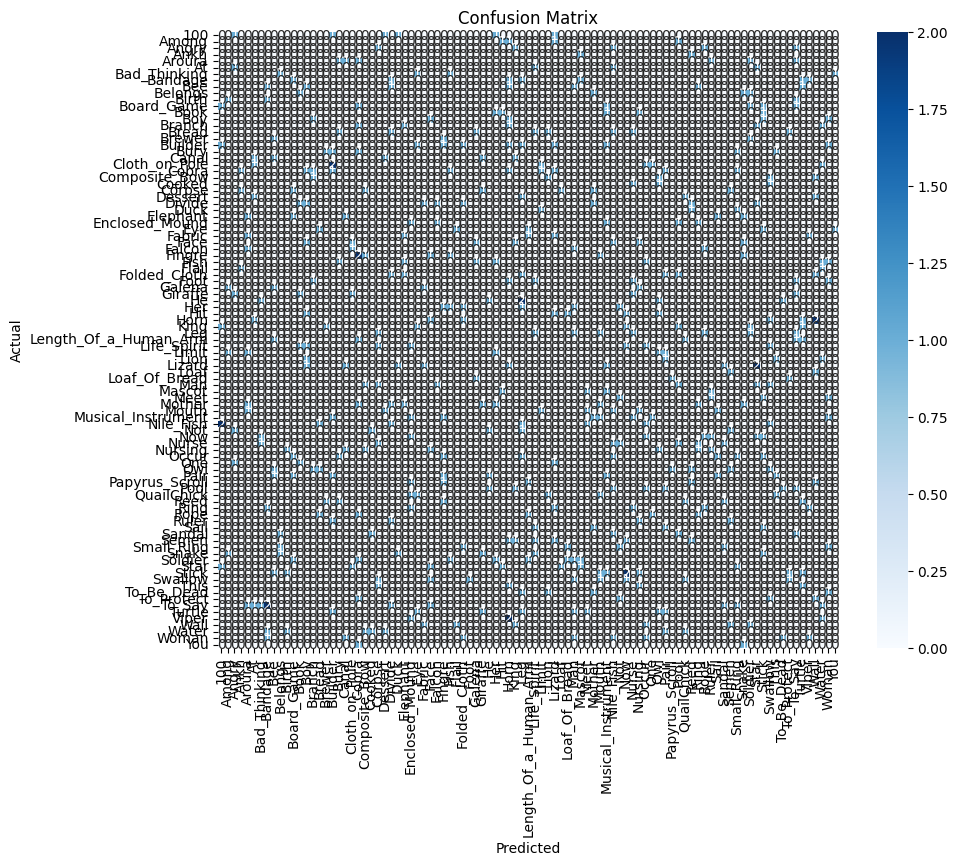

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load image (replace with path to your test image)
img_path = '/content/FOLDER/test/wall-19-_jpg.rf.3b2877afde86754be66383492e032002.jpg'  # or any hieroglyph image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # same as rescale=1./255

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Map index to class name
class_labels = list(train_generator.class_indices.keys())
print("Predicted class:", class_labels[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: Wall


In [18]:
# Assuming 'model' is your trained model
model.save("hieroglyph_model.keras")
print("Model saved successfully as hieroglyph_model.keras")

Model saved successfully as hieroglyph_model.keras


In [19]:
from google.colab import files
files.download('hieroglyph_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import os
print(os.listdir('.'))

['.config', 'FOLDER', 'hieroglyph_model.keras', 'drive', 'sample_data']


In [21]:
rm -r FOLDER